In [1]:
from osgeo import gdal
gdal.UseExceptions()

ds: gdal.Dataset = gdal.Open("./mola_data.tif")

In [2]:
band: gdal.Band = ds.GetRasterBand(1)
print(f"Raster size: {band.XSize} x {band.YSize}")

minimum, maximum, mean, stddev = band.GetStatistics(True, True)

print(f"Min: {minimum}, Max: {maximum}, Mean: {mean}, StdDev: {stddev}")

Raster size: 46080 x 23040
Min: -8061.0, Max: 20737.0, Mean: -726.00892466065, StdDev: 2970.7799910895


In [3]:
import typing
import struct

def read_horizontal_scanline(x_offset: int, y_offset: int, width: int) -> tuple[float]:
    try:
        scanline = band.ReadRaster(
            xoff=x_offset,
            yoff=y_offset,
            xsize=width,
            ysize=1,
            buf_xsize=width,
            buf_ysize=1,
            buf_type=gdal.GDT_Float32
        )
    except RuntimeError:
        print("Caught RuntimeError while reading scanline:")
        print("x_offset", x_offset)
        print("y_offset", y_offset)
        print("width", width)
        raise

    return typing.cast(tuple[float], struct.unpack('f' * width, scanline))


For example, let's try to chart the elevation of a line through Olympus Mons:

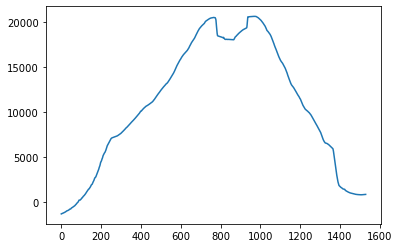

In [5]:
from matplotlib import pyplot as plt

start_x = 5135
end_x = 6665
start_y = 9188  # Approximately the middle of the mountain in terms of North/South

line = read_horizontal_scanline(start_x, start_y, end_x - start_x)

plt.plot(line)

Here is a top-down satellite image of the same volcano:
![olympus_mons.png](olympus_mons.png)

Let's do the same for all our known_features.

In [6]:
IMAGE_HEIGHT = 23040
IMAGE_WIDTH = 46080

def coord_to_x_y(lat: float, long: float) -> tuple[float, float]:
    """
    :param lat: -90 to 90
    :param long: -180 to 180
    :return: x, y pixel coordinates from the tiff image
    """
    x = ((long + 180) / 360) * IMAGE_WIDTH
    y = ((-lat + 90) / 180) * IMAGE_HEIGHT

    return round(x), round(y)

coord_to_x_y(18.68, -133.8)

(5914, 9129)

In [7]:
def get_scanlines_to_read(start_x: int, end_x: int, start_y: int, end_y: int) -> list[tuple[int, tuple[int, int]]]:
    slope = (end_x - start_x) / (end_y - start_y + 1)  # For every y, how many x's do we change
    x_size = round(slope) + 1

    result = []

    for y in range(start_y, end_y + 1):
        first_x = round(slope * (y - start_y)) + start_x
        last_x = first_x + x_size

        result.append((y, (first_x, last_x)))

    return result

# start_x, start_y = coord_to_x_y(23.68, -139.24)
# end_x, end_y = coord_to_x_y(18.65, -127.8)
# end_x, end_y = coord_to_x_y(23.67, -127.8)
# end_x, end_y = coord_to_x_y(18.65, -139.24)

# print(start_x, start_y)
# print(end_x, end_y)
#
# get_scanlines_to_read(start_x, end_x, start_y, end_y)

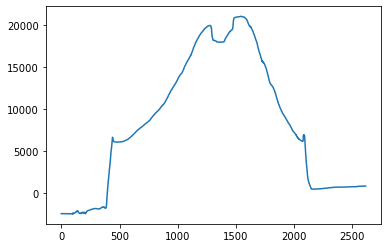

In [8]:
def read_line(start_x: int, start_y: int, end_x: int, end_y: int) -> list[float]:
    lines = get_scanlines_to_read(start_x, end_x, start_y, end_y)

    result = []

    for line in lines:
        y = line[0]
        x = line[1]
        result += read_horizontal_scanline(x[0], y, x[1] - x[0])

    return result

start_x, start_y = coord_to_x_y(23.68, -139.24)
end_x, end_y = coord_to_x_y(13.48, -127.8)

line = read_line(start_x, start_y, end_x, end_y)

plt.plot(line)

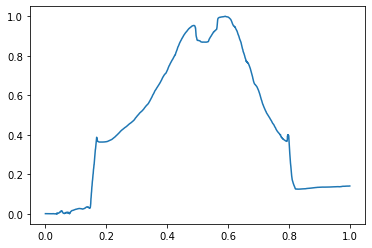

In [9]:
NormalizedLine = list[tuple[float, float]]

def normalize(line: list[float]) -> NormalizedLine:
    length = len(line)

    min_height = min(line)
    max_height = max(line)

    height_diff = max_height - min_height

    return [(i/length, (line[i] - min_height) / height_diff) for i in range(length)]

normalized = normalize(line)

xs, ys = zip(*normalized)

plt.plot(xs, ys)

In [10]:
import json

with open("known_features.json", "r") as f:
    data = f.read()

features = json.loads(data)

def find_features(**kwargs) -> list[dict]:
    result = []

    for feature in features:
        matches = True
        for key in kwargs:
            try:
                if feature[key] != kwargs[key]:
                    matches = False
                    break
            except KeyError:
                matches = False
                break

        if matches:
            result.append(feature)

    return result

print(find_features(featuretype="Mons, montes"))

[{'name': 'Hadriacus Mons', 'target': 'MARS', 'system': 'MARS', 'diameter': '450', 'centerlatitude': '-31.29', 'centerlongitude': '91.86', 'northernLatitude': '-28.12', 'southernLatitude': '-35.09', 'easternLongitude': '95.22', 'westernLongitude': '88.7', 'coordinateSystem': 'Planetocentric, +East, -180 - 180', 'approvalstatus': 'Adopted by IAU', 'approvaldate': 'Sep 19, 2007', 'featuretype': 'Mons, montes', 'origin': 'Classical albedo feature name.'}, {'name': 'Libya Montes', 'target': 'MARS', 'system': 'MARS', 'diameter': '1043.63', 'centerlatitude': '1.44', 'centerlongitude': '88.23', 'northernLatitude': '6.57', 'southernLatitude': '-1.22', 'easternLongitude': '96.59', 'westernLongitude': '78.99', 'coordinateSystem': 'Planetocentric, +East, -180 - 180', 'approvalstatus': 'Adopted by IAU', 'approvaldate': '1979', 'featuretype': 'Mons, montes', 'origin': 'Classical albedo feature name.'}, {'name': 'Hellespontus Montes', 'target': 'MARS', 'system': 'MARS', 'diameter': '711.46', 'center

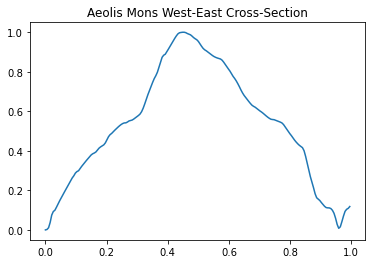

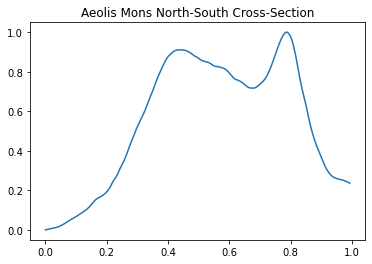

In [14]:
def generate_normalized_cross_sections(feature: dict) -> tuple[NormalizedLine, NormalizedLine]:
    start_x, start_y = coord_to_x_y(float(feature["northernLatitude"]), float(feature["westernLongitude"]))
    end_x, end_y = coord_to_x_y(float(feature["southernLatitude"]), float(feature["easternLongitude"]))

    horizontal_midpoint = round((start_x + end_x) / 2)
    vertical_midpoint = round((start_y + end_y) / 2)

    try:
        horizontal_cs = normalize(read_line(start_x, vertical_midpoint, end_x, vertical_midpoint))
        vertical_cs = normalize(read_line(horizontal_midpoint, start_y, horizontal_midpoint, end_y))
    except RuntimeError:
        print("Runtime error generated while trying to read line for", feature["name"])
        raise

    return horizontal_cs, vertical_cs

def graph_feature(feature: dict):
    cross_sections = generate_normalized_cross_sections(feature)

    for i, graph in enumerate(cross_sections):
        xs, ys = zip(*graph)
        plt.plot(xs, ys)
        plt.title(f"{feature['name']} {'West-East' if not i else 'North-South'} Cross-Section")
        plt.show()

features_to_graph = ["Aeolis Mons"]

for feature_name in features_to_graph:
    feature = find_features(name=feature_name)[0]

    assert feature is not None

    graph_feature(feature)

In [15]:
def get_y_value(line: NormalizedLine, x: float) -> float:
    xs, ys = zip(*line)

    indx = None

    for i, x_ in enumerate(xs):
        if x_ >= x:
            indx = i
            break

    if indx == None:
        indx = len(line) - 1

    # if indx is None:
    #     raise ValueError("Invalid x value provided. Should be between 0 and 1.")

    if len(line) - 1 == indx:
        return ys[indx]

    next_indx = indx + 1

    return (ys[indx] + ys[next_indx]) / 2

olympus_mons = find_features(name="Aeolis Mons")[0]

cs = generate_normalized_cross_sections(olympus_mons)

get_y_value(cs[0], .5)

0.9473355537052457

In [16]:
def generate_archetype(feature_type: str) -> tuple[NormalizedLine, int]:
    """
    :param feature_type: Mons, Crater, etc.
    :return: Archetype, and the number of features found matching the criteria
    """
    features = find_features(featuretype=feature_type)

    cross_sections = [item for feature in features for item in generate_normalized_cross_sections(feature)]

    num_cs = len(cross_sections)

    result = []

    x = 0
    while x < 1:
        s = 0.0

        for cs in cross_sections:
            s += get_y_value(cs, x)

        result.append((x, s / num_cs))

        x += 0.01

    return result, len(features)


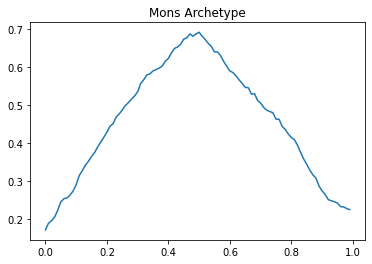

In [17]:
mons_archetype, _ = generate_archetype("Mons, montes")

xs, ys = zip(*mons_archetype)

plt.plot(xs, ys)
plt.title("Mons Archetype")
plt.show()

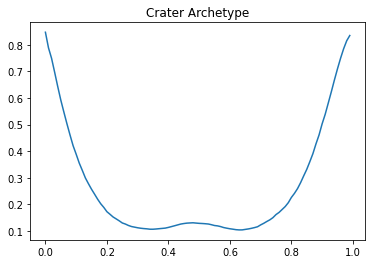

In [18]:
crater_archetype, _ = generate_archetype("Crater, craters")

xs, ys = zip(*crater_archetype)

plt.plot(xs, ys)
plt.title("Crater Archetype")
plt.show()

In [19]:
all_feature_types = set([feature["featuretype"] for feature in features])

archetypes = {}

for feature_type in all_feature_types:
    print(feature_type)

    archetype, n = generate_archetype(feature_type)

    archetypes[feature_type] = (archetype, n)

Mensa, mensae
Fossa, fossae
Patera, paterae
Chaos, chaoses
Chasma, chasmata
Mons, montes
Planum, plana
Rupes, rupēs
Cavus, cavi
Crater, craters
Vallis, valles
Tholus, tholi
Collis, colles
Dorsum, dorsa


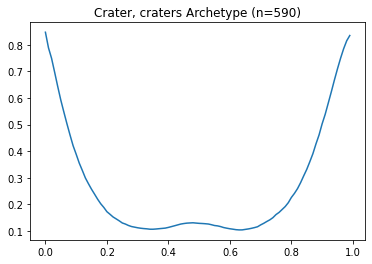

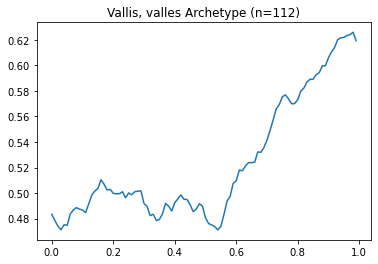

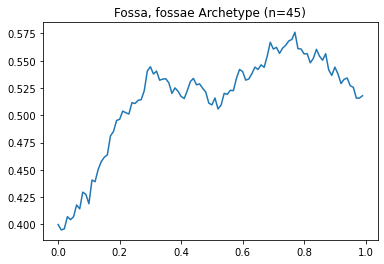

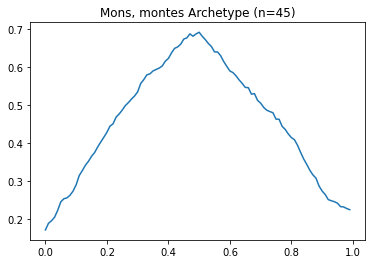

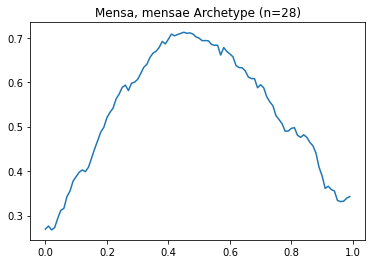

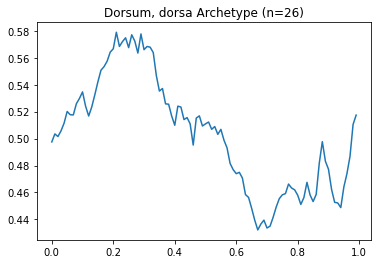

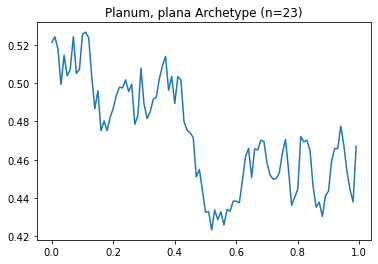

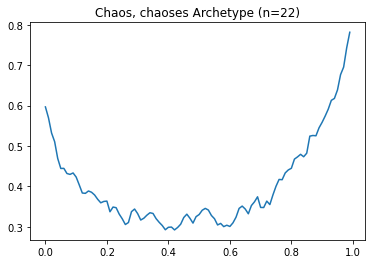

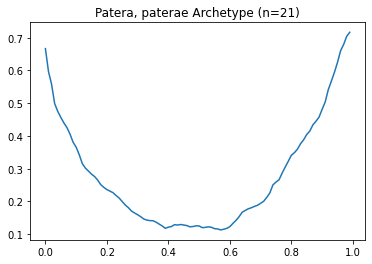

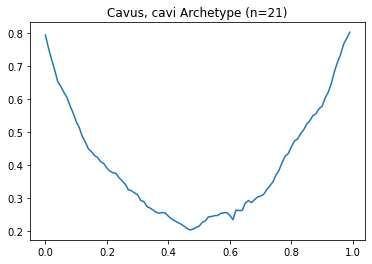

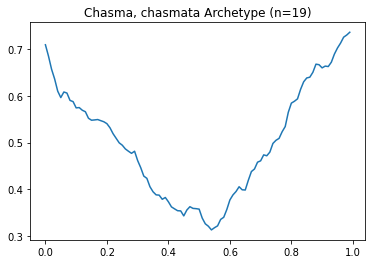

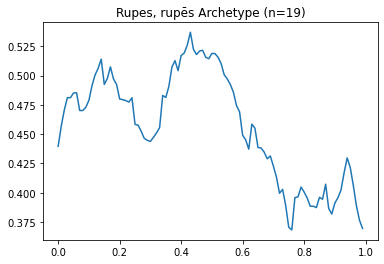

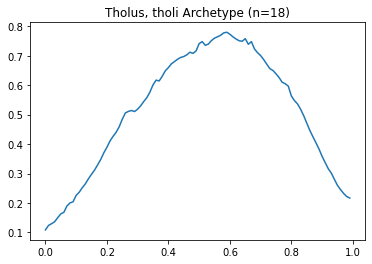

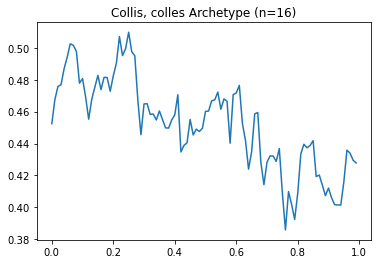

In [20]:
# Sort by archetypes by number of samples
sorted_feature_types = sorted(all_feature_types, key=lambda x: -archetypes[x][1])

# Plot only the ones where samples > 20
for feature_type in sorted_feature_types:
    archetype, n = archetypes[feature_type]

    xs, ys = zip(*archetype)

    plt.plot(xs, ys)
    plt.title(f"{feature_type} Archetype (n={n})")
    plt.show()

Save our archetypes to a file for loading later

In [21]:
import json
dumped = json.dumps(archetypes)

with open("archetypes.json", "w") as f:
    f.write(dumped)